In [1]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [40]:
x_cell = np.loadtxt('./data/traindata_cell-2.txt')
x_tissue = np.loadtxt('./data/traindata_tissue-2.txt')
x_hact =  np.loadtxt('./data/traindata-2.txt')

y_cell = np.loadtxt('./data/traindataanswers_cell-2.txt')
y_tissue = np.loadtxt('./data/traindataanswers_tissue-2.txt')
y_hact = np.loadtxt('.data/traindataanswers-2.txt')

In [20]:
def traingbm_find_best(train_data, test_data, objective,error,classes):
    param = {
        "objective": objective,
        "num_class": classes,
        "metric": error,
        "verbose": -1,
        "learning_rate": 0.1,
        "num_leaves": 191,
        "feature_fraction": 0.46,
        "bagging_fraction": 0.69,
        "bagging_freq": 0,
        "max_depth": 7,
    }
    evals = {}
    gbm = lgb.train(param, train_data,100,valid_sets=[test_data], callbacks = [lgb.record_evaluation(evals)])
    return evals
    


In [21]:
def svm_score(x_train,y_train,x_test,y_test):
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
    m = GridSearchCV(svm.SVC(), param_grid,refit = True, verbose = -1)
    m.fit(x_train,y_train)
    scores= m.predict(x_test)
    return classification_report(scores,y_test)

In [22]:
def log_score(x_train,y_train,x_test,y_test):
    param_grid = [
    {
     'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}]
    m = GridSearchCV(LogisticRegression(), param_grid, cv = 5, verbose = True, n_jobs = -1)
    m.fit(x_train,y_train)
    score = m.predict(x_test)
    return classification_report(score,y_test)


In [25]:
def data_analysis(x,y):
    binary = []
    for i in range(len(y)):
        if y[i] == 0 or y[i] == 1:
            binary.append(0)
        else:
            binary.append(1)
    binary = np.array(binary)
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.1)
    x_bin_train, x_bin_test, y_bin_train, y_bin_test = train_test_split(x,binary,test_size = 0.1)
    train_data = lgb.Dataset(x_train, label=y_train)
    test_data = lgb.Dataset(x_test, label=y_test)
    bin_train_data  = lgb.Dataset(x_bin_train,label= y_bin_train)
    bin_test_data = lgb.Dataset(x_bin_test,label = y_bin_test)
    

    bestscores = {}
    print(train_data,test_data)
    bestscores['gen_gbm'] = traingbm_find_best(train_data, test_data,'multiclass',["multi_logloss", "multi_error"],4)
    bestscores['bin_gbm'] = traingbm_find_best(bin_train_data, bin_test_data,'binary',['binary_logloss','binary_error'],1)

    bestscores['gen_svm'] = svm_score(x_train,y_train,x_test,y_test)
    bestscores['bin_svm'] = svm_score(x_bin_train, y_bin_train, x_bin_test, y_bin_test)

    bestscores['gen_log'] = log_score(x_train,y_train,x_test,y_test)
    bestscores['bin_log'] = log_score(x_bin_train, y_bin_train, x_bin_test, y_bin_test)

    return bestscores


In [41]:
hact = data_analysis(x_hact,y_hact)
print('hact complete!')
cell = data_analysis(x_cell,y_cell)
print('cell complete!')
tissue = data_analysis(x_tissue, y_tissue)
print('tissue complete!')

<lightgbm.basic.Dataset object at 0x00000172F5241E20> <lightgbm.basic.Dataset object at 0x00000172F3D8A8B0>
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
hact complete!
<lightgbm.basic.Dataset object at 0x000001729F3CA400> <lightgbm.basic.Dataset object at 0x00000172F50454F0>
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
cell complete!
<lightgbm.basic.Dataset object at 0x00000172F3E7C670> <lightgbm.basic.Dataset object at 0x00000172F501F130>
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
tissue complete!


In [42]:
print(' ---------------- HACT RESULTS ---------------- ')

print('hact multiclass gbm:', min(hact['gen_gbm']['valid_0']['multi_logloss']))
print('hact binary gbm:', min(hact['bin_gbm']['valid_0']['binary_logloss']))


 ---------------- HACT RESULTS ---------------- 
hact multiclass gbm: 1.0852403080539461
hact binary gbm: 0.44748886097759205


In [43]:
print(' ---------------- CELL RESULTS ---------------- ')

print('cell multiclass gbm:', min(cell['gen_gbm']['valid_0']['multi_logloss']))
print('cell normal binary gbm:', min(cell['bin_gbm']['valid_0']['binary_logloss']))


 ---------------- CELL RESULTS ---------------- 
cell multiclass gbm: 1.3245758452413536
cell normal binary gbm: 0.674200917196772


In [44]:
print(' ---------------- TISSUE RESULTS ---------------- ')

print('tissue multiclass gbm:', min(tissue['gen_gbm']['valid_0']['multi_logloss']))
print('tissue normal binary gbm:', min(tissue['bin_gbm']['valid_0']['binary_logloss']))

 ---------------- TISSUE RESULTS ---------------- 
tissue multiclass gbm: 0.8604707980258962
tissue normal binary gbm: 0.6216012742306739


[0.5806451612903226, 0.5161290322580645, 0.45161290322580644, 0.5161290322580645, 0.45161290322580644, 0.5161290322580645, 0.5806451612903226, 0.5483870967741935, 0.5483870967741935, 0.5483870967741935, 0.5483870967741935, 0.5161290322580645, 0.5483870967741935, 0.5483870967741935, 0.5161290322580645, 0.5161290322580645, 0.5483870967741935, 0.5161290322580645, 0.5483870967741935, 0.5483870967741935, 0.5483870967741935, 0.5483870967741935, 0.5806451612903226, 0.5483870967741935, 0.5483870967741935, 0.5806451612903226, 0.5483870967741935, 0.5806451612903226, 0.5806451612903226, 0.5806451612903226, 0.5806451612903226, 0.5806451612903226, 0.5806451612903226, 0.5806451612903226, 0.5806451612903226, 0.5806451612903226, 0.5483870967741935, 0.5483870967741935, 0.5161290322580645, 0.5161290322580645, 0.5161290322580645, 0.5483870967741935, 0.5483870967741935, 0.5483870967741935, 0.5483870967741935, 0.5161290322580645, 0.5161290322580645, 0.5161290322580645, 0.5161290322580645, 0.548387096774193

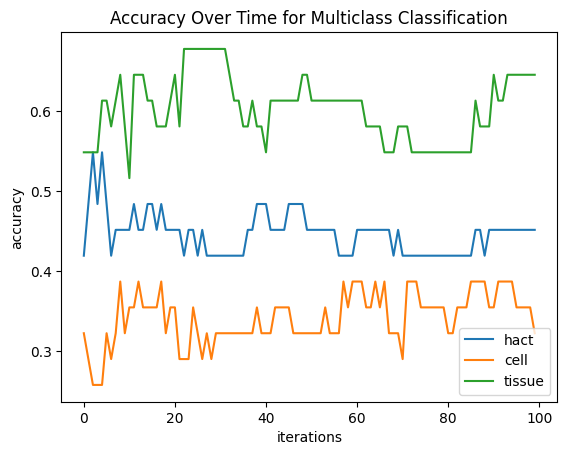

In [45]:
print(hact['gen_gbm']['valid_0']['multi_error'])
acc = []
for i in hact['gen_gbm']['valid_0']['multi_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'hact')
print(max(acc))

print(cell['gen_gbm']['valid_0']['multi_error'])
acc = []
for i in cell['gen_gbm']['valid_0']['multi_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'cell')
print(max(acc))
print(tissue['gen_gbm']['valid_0']['multi_error'])
acc = []
for i in tissue['gen_gbm']['valid_0']['multi_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'tissue')
print(max(acc))
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy Over Time for Multiclass Classification')
plt.legend()
plt.show()


[0.25806451612903225, 0.25806451612903225, 0.3225806451612903, 0.25806451612903225, 0.2903225806451613, 0.3225806451612903, 0.3548387096774194, 0.3225806451612903, 0.2903225806451613, 0.3225806451612903, 0.25806451612903225, 0.25806451612903225, 0.2903225806451613, 0.25806451612903225, 0.2903225806451613, 0.2903225806451613, 0.2903225806451613, 0.25806451612903225, 0.2903225806451613, 0.2903225806451613, 0.25806451612903225, 0.22580645161290322, 0.22580645161290322, 0.22580645161290322, 0.25806451612903225, 0.25806451612903225, 0.22580645161290322, 0.22580645161290322, 0.25806451612903225, 0.22580645161290322, 0.22580645161290322, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.22580645161290322, 0.22580645161290322, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.16129032258064516, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742

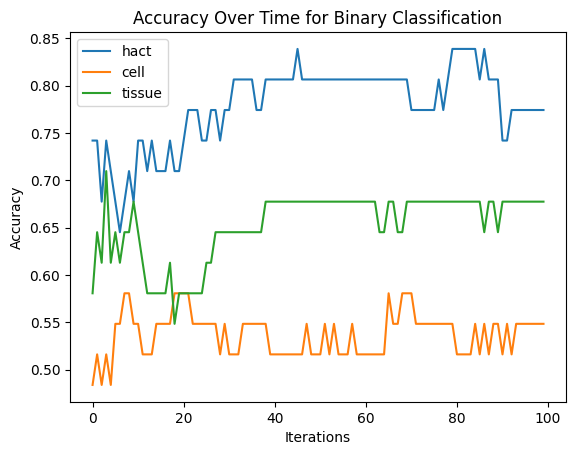

In [46]:
print(hact['bin_gbm']['valid_0']['binary_error'])
acc = []
for i in hact['bin_gbm']['valid_0']['binary_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'hact')
print(max(acc))

print(cell['bin_gbm']['valid_0']['binary_error'])
acc = []
for i in cell['bin_gbm']['valid_0']['binary_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'cell')
print(max(acc))
print(tissue['bin_gbm']['valid_0']['binary_error'])
acc = []
for i in tissue['bin_gbm']['valid_0']['binary_error']:
    acc.append(1-i)
plt.plot(range(len(acc)), acc, label = 'tissue')
print(max(acc))
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time for Binary Classification')
plt.legend()
plt.show()


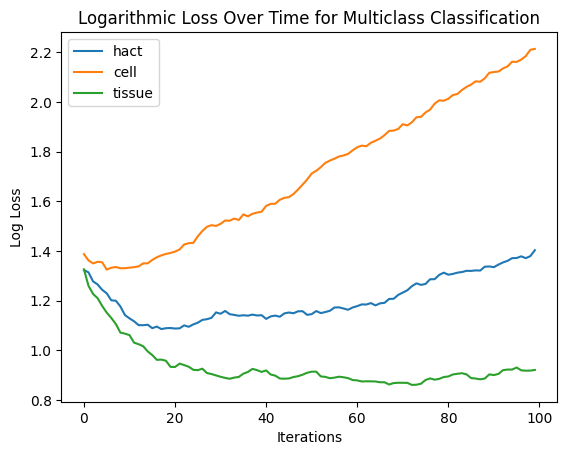

In [47]:
plt.plot(range(len(hact['gen_gbm']['valid_0']['multi_logloss'])), hact['gen_gbm']['valid_0']['multi_logloss'], label = 'hact')
plt.plot(range(len(cell['gen_gbm']['valid_0']['multi_logloss'])), cell['gen_gbm']['valid_0']['multi_logloss'], label = 'cell')
plt.plot(range(len(tissue['gen_gbm']['valid_0']['multi_logloss'])), tissue['gen_gbm']['valid_0']['multi_logloss'], label = 'tissue')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Logarithmic Loss Over Time for Multiclass Classification')
plt.legend()
plt.show()

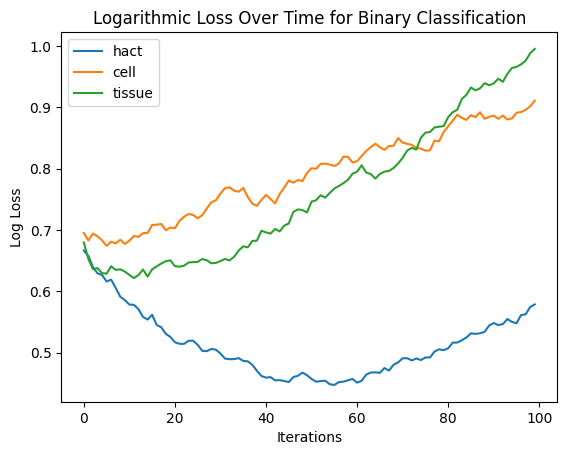

In [48]:
plt.plot(range(len(hact['bin_gbm']['valid_0']['binary_logloss'])), hact['bin_gbm']['valid_0']['binary_logloss'], label = 'hact')
plt.plot(range(len(cell['bin_gbm']['valid_0']['binary_logloss'])), cell['bin_gbm']['valid_0']['binary_logloss'], label = 'cell')
plt.plot(range(len(tissue['bin_gbm']['valid_0']['binary_logloss'])), tissue['bin_gbm']['valid_0']['binary_logloss'], label = 'tissue')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Logarithmic Loss Over Time for Binary Classification')
plt.legend()
plt.show()

In [49]:
print(' ---------------- HACT RESULTS ---------------- ')
print('multiclass support vector classification')
print(hact['gen_svm'])
print('binary normal support vector classification')
print(hact['bin_svm'])

 ---------------- HACT RESULTS ---------------- 
multiclass support vector classification
              precision    recall  f1-score   support

         0.0       0.55      0.75      0.63         8
         1.0       0.50      0.27      0.35        11
         2.0       0.40      0.50      0.44         8
         3.0       0.50      0.50      0.50         4

    accuracy                           0.48        31
   macro avg       0.49      0.51      0.48        31
weighted avg       0.49      0.48      0.47        31

binary normal support vector classification
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.80      0.84      0.82        19

    accuracy                           0.77        31
   macro avg       0.76      0.75      0.76        31
weighted avg       0.77      0.77      0.77        31



In [50]:
print(' ---------------- HACT RESULTS ---------------- ')
print('multiclass logistic regression')
print(hact['gen_log'])
print('binary normal logistic regression')
print(hact['bin_log'])

 ---------------- HACT RESULTS ---------------- 
multiclass logistic regression
              precision    recall  f1-score   support

         0.0       0.55      0.75      0.63         8
         1.0       0.50      0.43      0.46         7
         2.0       0.50      0.71      0.59         7
         3.0       0.75      0.33      0.46         9

    accuracy                           0.55        31
   macro avg       0.57      0.56      0.54        31
weighted avg       0.58      0.55      0.53        31

binary normal logistic regression
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        13
           1       0.80      0.89      0.84        18

    accuracy                           0.81        31
   macro avg       0.81      0.79      0.80        31
weighted avg       0.81      0.81      0.80        31



In [51]:
print(' ---------------- CELL RESULTS ---------------- ')
print('multiclass support vector classification')
print(cell['gen_svm'])
print('binary normal support vector classification')
print(cell['bin_svm'])

 ---------------- CELL RESULTS ---------------- 
multiclass support vector classification
              precision    recall  f1-score   support

         0.0       0.33      0.29      0.31         7
         1.0       0.10      0.20      0.13         5
         2.0       0.75      0.25      0.38        12
         3.0       0.36      0.57      0.44         7

    accuracy                           0.32        31
   macro avg       0.39      0.33      0.32        31
weighted avg       0.46      0.32      0.34        31

binary normal support vector classification
              precision    recall  f1-score   support

           0       0.54      0.54      0.54        13
           1       0.67      0.67      0.67        18

    accuracy                           0.61        31
   macro avg       0.60      0.60      0.60        31
weighted avg       0.61      0.61      0.61        31



In [52]:
print(' ---------------- CELL RESULTS ---------------- ')
print('multiclass logistic regression')
print(cell['gen_log'])
print('binary normal logistic regression')
print(cell['bin_log'])

 ---------------- CELL RESULTS ---------------- 
multiclass logistic regression
              precision    recall  f1-score   support

         0.0       0.33      0.25      0.29         8
         1.0       0.00      0.00      0.00         3
         2.0       0.50      0.17      0.25        12
         3.0       0.45      0.62      0.53         8

    accuracy                           0.29        31
   macro avg       0.32      0.26      0.27        31
weighted avg       0.40      0.29      0.31        31

binary normal logistic regression
              precision    recall  f1-score   support

           0       0.62      0.47      0.53        17
           1       0.50      0.64      0.56        14

    accuracy                           0.55        31
   macro avg       0.56      0.56      0.55        31
weighted avg       0.56      0.55      0.55        31



In [53]:
print(' ---------------- TISSUE RESULTS ---------------- ')
print('multiclass support vector classification')
print(tissue['gen_svm'])
print('binary normal support vector classification')
print(tissue['bin_svm'])

 ---------------- TISSUE RESULTS ---------------- 
multiclass support vector classification
              precision    recall  f1-score   support

         0.0       0.56      0.71      0.63         7
         1.0       0.80      0.50      0.62         8
         2.0       0.67      0.55      0.60        11
         3.0       0.62      1.00      0.77         5

    accuracy                           0.65        31
   macro avg       0.66      0.69      0.65        31
weighted avg       0.67      0.65      0.64        31

binary normal support vector classification
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.71      0.71      0.71        17

    accuracy                           0.68        31
   macro avg       0.67      0.67      0.67        31
weighted avg       0.68      0.68      0.68        31



In [54]:
print(' ---------------- TISSUE RESULTS ---------------- ')
print('multiclass logistic regression')
print(tissue['gen_log'])
print('binary normal logistic regression')
print(tissue['bin_log'])

 ---------------- TISSUE RESULTS ---------------- 
multiclass logistic regression
              precision    recall  f1-score   support

         0.0       0.67      0.55      0.60        11
         1.0       0.20      0.20      0.20         5
         2.0       0.56      0.50      0.53        10
         3.0       0.62      1.00      0.77         5

    accuracy                           0.55        31
   macro avg       0.51      0.56      0.52        31
weighted avg       0.55      0.55      0.54        31

binary normal logistic regression
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.82      0.78      0.80        18

    accuracy                           0.77        31
   macro avg       0.77      0.77      0.77        31
weighted avg       0.78      0.77      0.78        31

